In [1]:
require(tidyverse)
require(rstan)
require(stringr)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract




In [2]:
#setwd('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200315_2_stage_impute_beta_no_missing/')
#setwd('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200319_2_stage_impute_beta_no_missing/')
setwd('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200728_fixed_prior_no_missing/')

In [3]:
make_df_raw = function(path) {
    setwd(path)
    files = list.files()
    print(length(files))
    files_keep = sapply(files,function(x) { str_detect(string=x,pattern = 'RAW_SIM_NUMBER_.*.csv') })
    print(sum(files_keep))
    files = files[files_keep]
    df = data.frame()
    suppressMessages(
        for(file in files) {
            df_file = read_csv(file,)
            df = df %>% bind_rows(df_file)
        }
    )
    #df = df %>% mutate(ppv = 1-fdr) %>% mutate(f1=1/(1/ppv+1/tpr))
    #df$Analysis=label
    df
}

In [4]:
#sim_data_ex = read_rds('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200303_beta_missing/RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.2_SIM_DATA.rds')
#fit_data_ex = read_rds('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200303_beta_missing/RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.2_FIT_DATA.rds')
#sum_table_ex = read_csv('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200303_beta_missing/RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.2.csv')

In [5]:
#sim_data = make_df_raw('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200315_2_stage_impute_beta_no_missing/')
#sim_data = make_df_raw('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200319_2_stage_impute_beta_no_missing/')
sim_data = make_df_raw('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200728_fixed_prior_no_missing/')

dim(sim_data)



[1] 4007
[1] 1000


[1] 4000   13

In [6]:
#sampler_params = get_sampler_params(fit_data_ex, inc_warmup=FALSE)[[1]]

#head(sampler_params)

#summary(sampler_params[,'n_leapfrog__'])
#summary(sampler_params[,'treedepth__'])
#summary(sampler_params[,'divergent__'])
#sum(sampler_params[,'divergent__'])

In [7]:
df_raw_sum = sim_data %>% group_by(MISSING_RATE,FRAC_SIG,N_SAMPLE,label) %>% 
    mutate(avg_mag_error_obs = !is.na(avg_mag_error) ) %>% summarise_all(function(x) { sum(x,na.rm = T)}) %>% mutate(
    fdr = fp/(tp+fp), tpr=tp/(tp+fn),
    fpr = fp/(fp + tn),
    avg_mag_error = avg_mag_error/avg_mag_error_obs) %>% 
    mutate(ppv = 1-fdr) %>% mutate(f1=2/(1/ppv+1/tpr))


sim_data %>% group_by(MISSING_RATE,FRAC_SIG,N_SAMPLE,label) %>% count()

MISSING_RATE,FRAC_SIG,N_SAMPLE,label,n
<dbl>,<dbl>,<dbl>,<chr>,<int>
0,0.4,25,bayes,200
0,0.4,25,bh,200
0,0.4,25,bon,200
0,0.4,25,raw,200
0,0.4,50,bayes,200
0,0.4,50,bh,200
0,0.4,50,bon,200
0,0.4,50,raw,200
0,0.4,75,bayes,200


In [8]:
df_raw_sum

MISSING_RATE,FRAC_SIG,N_SAMPLE,label,tp,fn,fp,tn,avg_mag_error,num_sign_error,n_sig,n_true,N_SIM,avg_mag_error_obs,fdr,tpr,fpr,ppv,f1
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.4,25,bayes,809,1391,225,2975,1.8844537,5,1034,2200,20100,192,0.217601547,0.36772727,0.0703125,0.7823985,0.50030921
0,0.4,25,bh,146,2054,9,3191,0.5057458,0,155,2200,20100,199,0.058064516,0.06636364,0.0028125,0.9419355,0.12399151
0,0.4,25,bon,49,2151,1,3199,0.4663217,0,50,2200,20100,199,0.020000000,0.02227273,0.0003125,0.9800000,0.04355556
0,0.4,25,raw,702,1498,150,3050,1.7429635,3,852,2200,20100,191,0.176056338,0.31909091,0.0468750,0.8239437,0.46002621
0,0.4,50,bayes,1291,909,217,2983,1.3687855,2,1508,2200,20100,200,0.143899204,0.58681818,0.0678125,0.8561008,0.69633225
0,0.4,50,bh,719,1481,49,3151,1.1492894,0,768,2200,20100,198,0.063802083,0.32681818,0.0153125,0.9361979,0.48450135
0,0.4,50,bon,386,1814,2,3198,1.0971296,0,388,2200,20100,199,0.005154639,0.17545455,0.0006250,0.9948454,0.29829985
0,0.4,50,raw,1239,961,188,3012,1.3266347,2,1427,2200,20100,200,0.131744919,0.56318182,0.0587500,0.8682551,0.68320926
0,0.4,75,bayes,1512,688,193,3007,1.2064538,0,1705,2200,20100,200,0.113196481,0.68727273,0.0603125,0.8868035,0.77439181


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



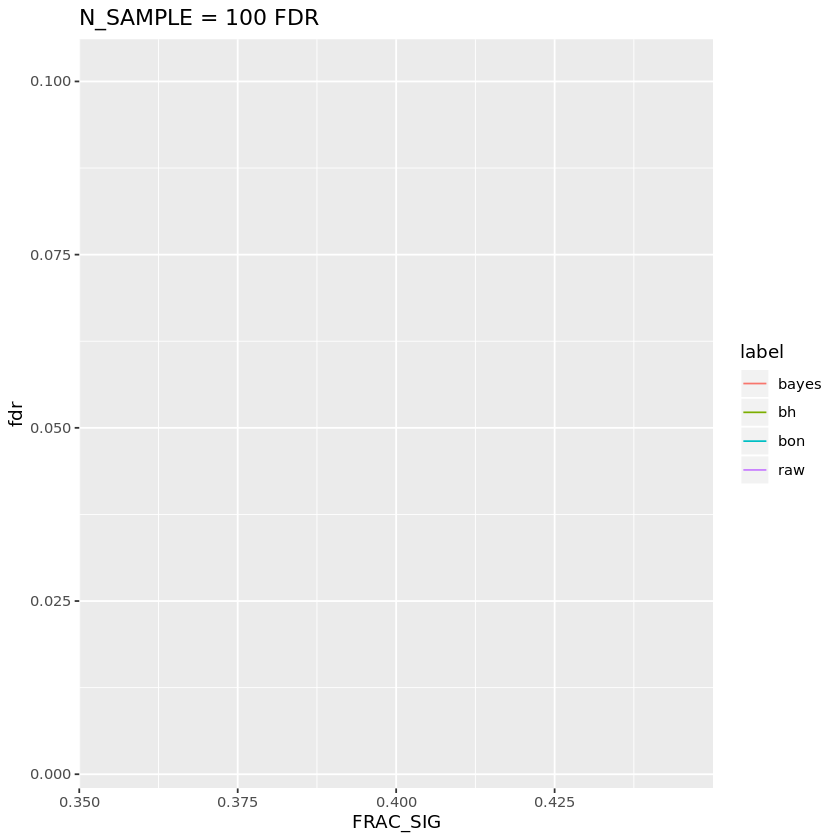

In [9]:
p = ggplot(df_raw_sum %>% filter(N_SAMPLE == 100)) + geom_line(aes(x=FRAC_SIG,y=fdr,color=label))
p = p + ggtitle(paste0("N_SAMPLE = ",100, " FDR "))
print(p)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



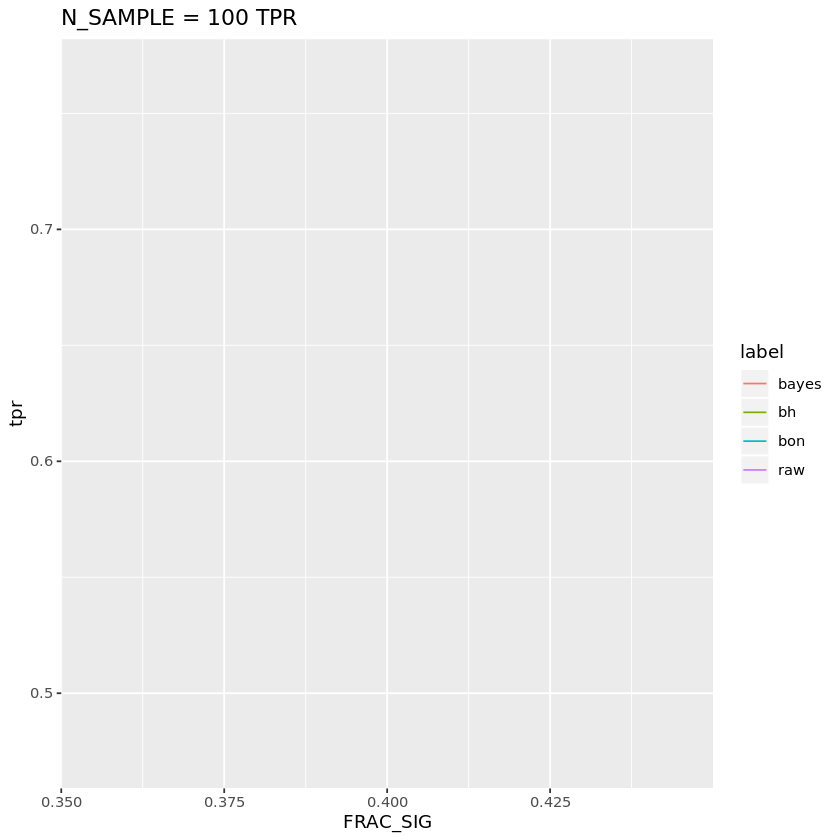

In [10]:
p = ggplot(df_raw_sum %>% filter(N_SAMPLE == 100)) + geom_line(aes(x=FRAC_SIG,y=tpr,color=label))
p = p + ggtitle(paste0("N_SAMPLE = ",100, " TPR "))
print(p)

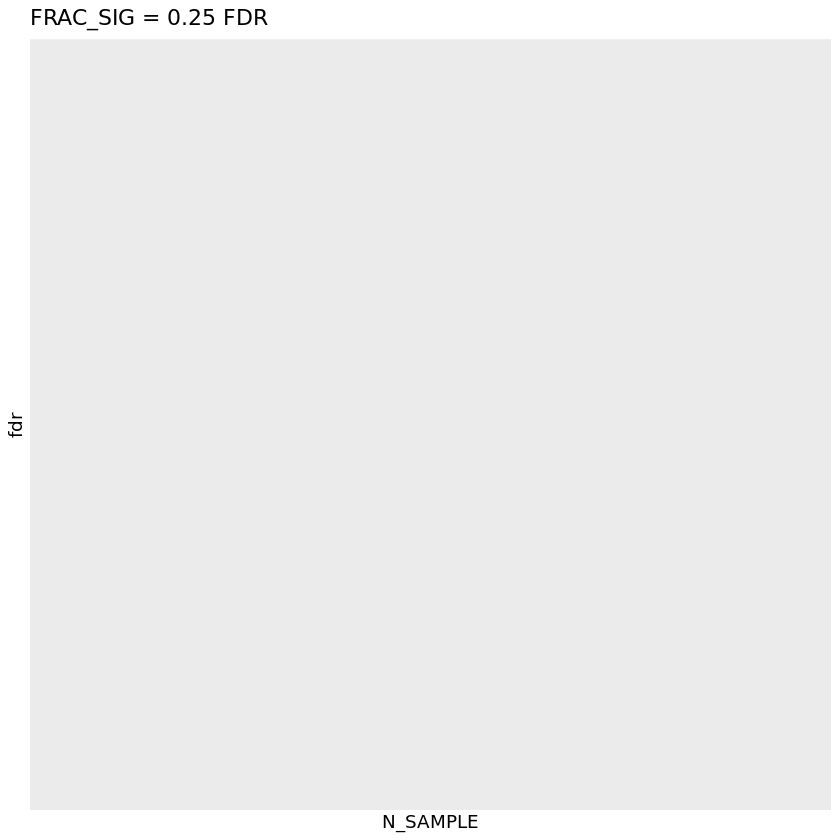

In [11]:
frac_sig = 0.25
p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=fdr,color=label))
p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " FDR "))
print(p)

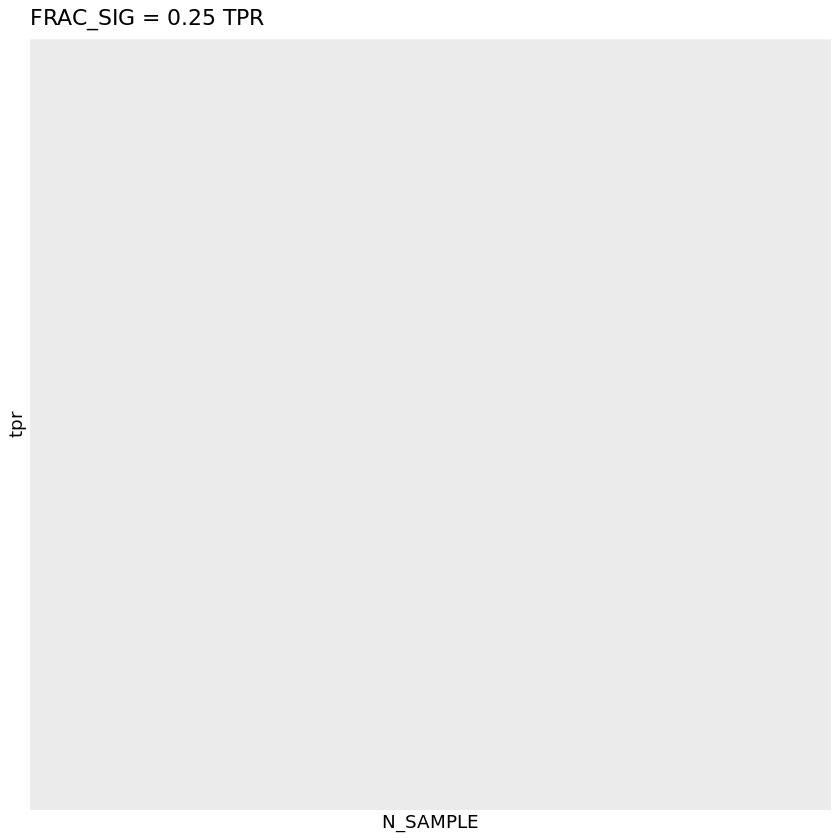

In [12]:
frac_sig = 0.25
p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=tpr,color=label))
p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " TPR "))
print(p)

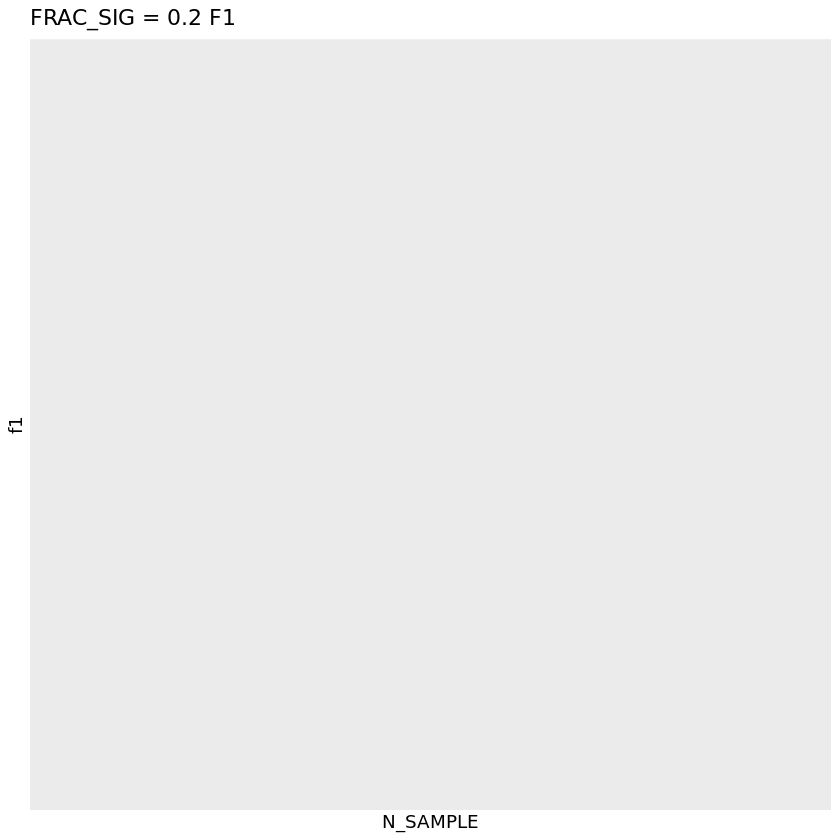

In [13]:
frac_sig = 0.2
p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=f1,color=label))
p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " F1 "))
print(p)

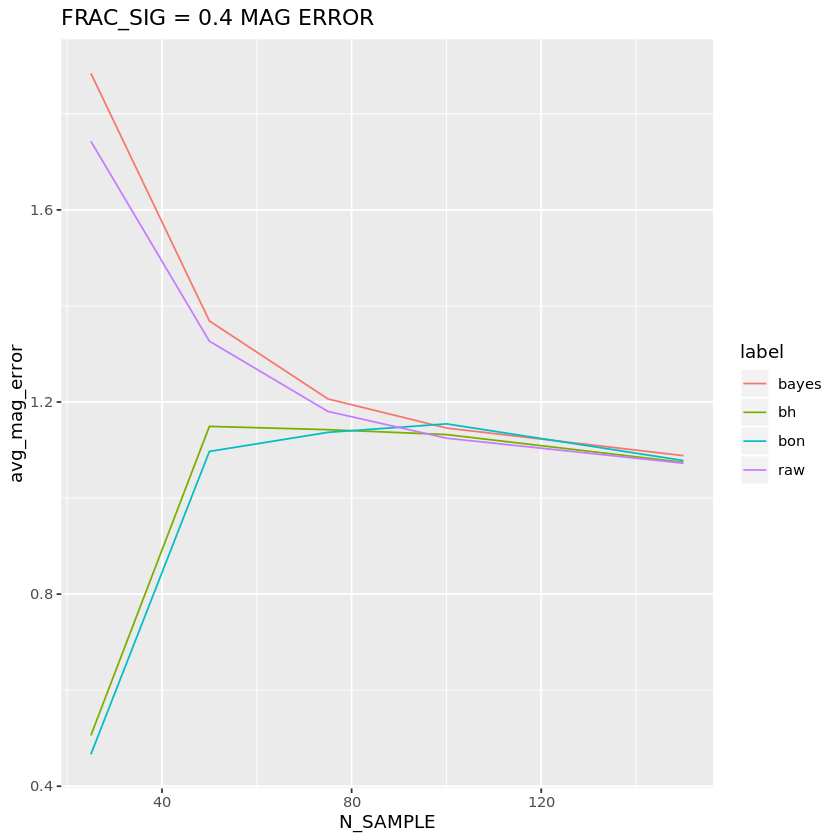

In [14]:
frac_sig = 0.4
p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=avg_mag_error,color=label))
p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " MAG ERROR "))
print(p)

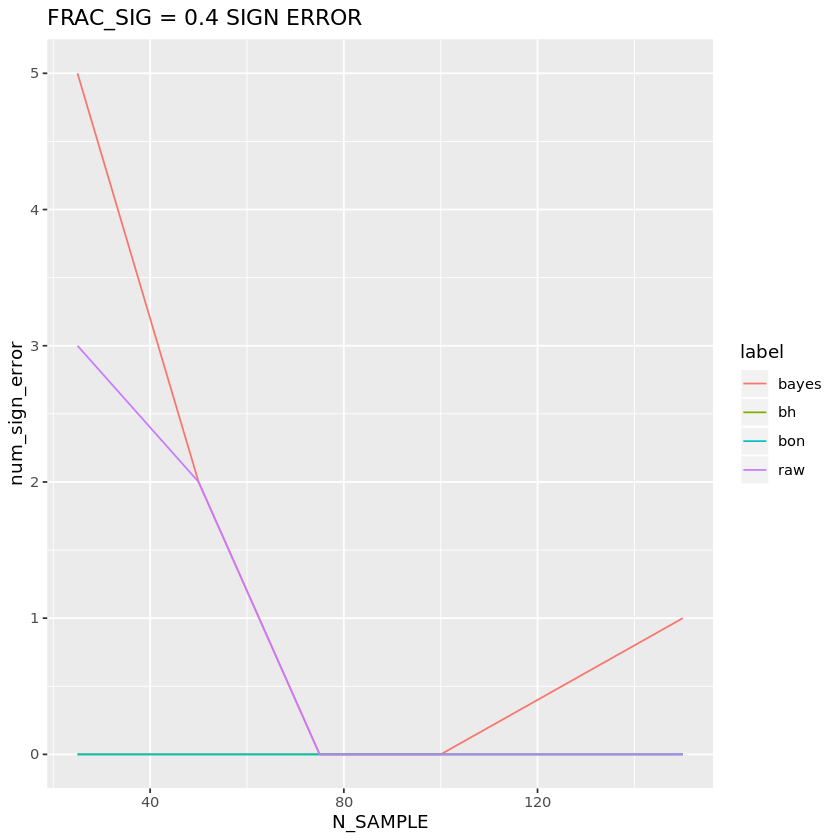

In [15]:
frac_sig = 0.4
p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=num_sign_error,color=label))
p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " SIGN ERROR "))
print(p)

In [16]:
df_raw_sum %>% head()

MISSING_RATE,FRAC_SIG,N_SAMPLE,label,tp,fn,fp,tn,avg_mag_error,num_sign_error,n_sig,n_true,N_SIM,avg_mag_error_obs,fdr,tpr,fpr,ppv,f1
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.4,25,bayes,809,1391,225,2975,1.8844537,5,1034,2200,20100,192,0.21760155,0.36772727,0.0703125,0.7823985,0.50030921
0,0.4,25,bh,146,2054,9,3191,0.5057458,0,155,2200,20100,199,0.05806452,0.06636364,0.0028125,0.9419355,0.12399151
0,0.4,25,bon,49,2151,1,3199,0.4663217,0,50,2200,20100,199,0.02000000,0.02227273,0.0003125,0.9800000,0.04355556
0,0.4,25,raw,702,1498,150,3050,1.7429635,3,852,2200,20100,191,0.17605634,0.31909091,0.0468750,0.8239437,0.46002621
0,0.4,50,bayes,1291,909,217,2983,1.3687855,2,1508,2200,20100,200,0.14389920,0.58681818,0.0678125,0.8561008,0.69633225
0,0.4,50,bh,719,1481,49,3151,1.1492894,0,768,2200,20100,198,0.06380208,0.32681818,0.0153125,0.9361979,0.48450135


In [17]:
df_raw_sum$FRAC_SIG %>% unique

[1] 0.4

In [18]:
pdf(paste0("plots_results_no_missing_nu_1.pdf"))
for(frac_sig in df_raw_sum$FRAC_SIG %>% unique) {
    p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=tpr,color=label))
    p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " TPR "))
    print(p)
    p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=fdr,color=label))
    p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " FDR "))
    print(p)
    p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=fpr,color=label))
    p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " FPR "))
    print(p)
    p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=f1,color=label))
    p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " F1 "))
    print(p)
    p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=((n_true-n_sig)/200)/(n_true/200),color=label)) + xlab("Fraction of underreported significance")
    p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " Fraction Under reported "))
    print(p)
    p = ggplot(df_raw_sum %>% filter(FRAC_SIG == frac_sig)) + geom_line(aes(x=N_SAMPLE,y=avg_mag_error,color=label))
    p = p + ggtitle(paste0("FRAC_SIG = ",frac_sig, " Magnitude Error Estimated Effect Size / Truth "))
    print(p)
}
dev.off()

png 
  2

In [19]:
write_csv(df_raw_sum, path='plots_results_no_missing_nu_1.csv')